# Initialization

Welcome to the NN assignment of "PGC-SEDS". 

Training your neural network requires specifying an initial value of the weights. A well chosen initialization method will help learning.  

If you completed the previous course of this specialization, you probably followed our instructions for weight initialization, and it has worked out so far. But how do you choose the initialization for a new neural network? In this notebook, you will see how different initializations lead to different results. 

A well chosen initialization can:
- Speed up the convergence of gradient descent
- Increase the odds of gradient descent converging to a lower training (and generalization) error 

To get started, run the following cell to load the packages and the planar dataset you will try to classify.

# Let’s define this network:

Neural networks can be constructed using the torch.nn package.

Now that you had a glimpse of autograd, nn depends on autograd to define models and differentiate them. An nn.Module contains layers, and a method forward(input) that returns the output.

For example, look at this network that classifies digit images:

# Define the network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the forward function, and the backward function (where gradients are computed) is automatically defined for you using autograd. You can use any of the Tensor operations in the forward function.

The learnable parameters of a model are returned by net.parameters()

In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


Let’s try a random 32x32 input. Note: expected input size of this net (LeNet) is 32x32. To use this net on the MNIST dataset, please resize the images from the dataset to 32x32.

In [4]:
# Create random input with 32x32 as input
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.1043, -0.0461,  0.0030,  0.1279, -0.0402,  0.0691,  0.0553,  0.0860,
          0.0741, -0.0326]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Zero the gradient buffers of all parameters and backprops with random gradients:

In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

Before proceeding further, let’s recap all the classes you’ve seen so far.

Recap:
  - torch.Tensor - A multi-dimensional array with support for autograd operations like backward(). Also holds the gradient w.r.t. the tensor.
  - nn.Module - Neural network module. Convenient way of encapsulating parameters, with helpers for moving them to GPU, exporting, loading, etc.
  - nn.Parameter - A kind of Tensor, that is automatically registered as a parameter when assigned as an attribute to a Module.
  - autograd.Function - Implements forward and backward definitions of an autograd operation. Every Tensor operation creates at least a single Function node that connects to functions that created a Tensor and encodes its history.

##At this point, we covered:
  - Defining a neural network
  - Processing inputs and calling backward
##Still Left:
  - Computing the loss
  - Updating the weights of the network

###Loss Function
A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target.

There are several different loss functions under the nn package . A simple loss is: nn.MSELoss which computes the mean-squared error between the input and the target.

In [6]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8690, grad_fn=<MseLossBackward>)


Now, if you follow loss in the backward direction, using its .grad_fn attribute, you will see a graph of computations that looks like this:



    input -> **conv2d** -> **relu** -> **maxpool2d** -> **conv2d** -> **relu** -> **maxpool2d**
      -> **flatten** -> **linear** -> **relu** -> **linear** -> **relu** -> **linear**
      -> **MSELoss**
      -> **loss**

So, when we call loss.backward(), the whole graph is differentiated w.r.t. the neural net parameters, and all Tensors in the graph that have requires_grad=True will have their .grad Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:

In [7]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU


##Backprop
To backpropagate the error all we have to do is to loss.backward(). You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

Now we shall call loss.backward(), and have a look at conv1’s bias gradients before and after the backward.

In [8]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0001,  0.0041, -0.0070,  0.0133, -0.0001, -0.0114])


## Update the weights
The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

    weight = weight - learning_rate * gradient

We can implement this using simple Python code:



In [9]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: torch.optim that implements all these methods. Using it is very simple:

In [10]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

#Training an image classifier
We will do the following steps in order:

Load and normalize the MNIST training and test datasets using torchvision
Define a Convolutional Neural Network
Define a loss function
Train the network on the training data
Test the network on the test data

##Load and normalize MNIST

Using torchvision, it’s extremely easy to load MNIST.



In [11]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

## TODO chnage the batch size and load the dataset

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



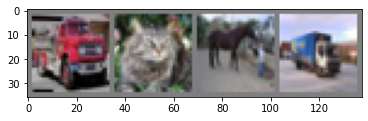

truck   cat horse truck


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

##Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before. 

In [55]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.



In [57]:
import torch.optim as optim
## Todo try two different optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network



>  This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.





### TODO change the no of epochs and train the model 

In [58]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.805
[1,  6000] loss: 1.659
[1,  8000] loss: 1.566
[1, 10000] loss: 1.547
[1, 12000] loss: 1.493
[2,  2000] loss: 1.433
[2,  4000] loss: 1.414
[2,  6000] loss: 1.355
[2,  8000] loss: 1.346
[2, 10000] loss: 1.339
[2, 12000] loss: 1.304
Finished Training


> Let’s quickly save our trained model:

In [60]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

> We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

> We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

> Okay, first step. Let us display an image from the test set to get familiar.

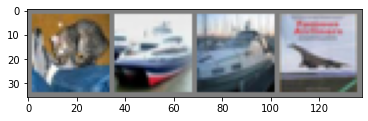

GroundTruth:    cat  ship  ship plane


In [59]:
# Loading the test data 
dataiter = iter(testloader)
images, labels = dataiter.next()
## Todo
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Let us look at how the network performs on the whole dataset.

In [61]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


> That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

> Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [62]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 61.8 %
Accuracy for class car   is: 63.2 %
Accuracy for class bird  is: 54.2 %
Accuracy for class cat   is: 27.3 %
Accuracy for class deer  is: 27.3 %
Accuracy for class dog   is: 49.2 %
Accuracy for class frog  is: 69.2 %
Accuracy for class horse is: 57.8 %
Accuracy for class ship  is: 69.0 %
Accuracy for class truck is: 64.3 %


### Todo 
> try to improve the accuracy changing the no of layers, epoch, optimizer 

> Okay, so what next?

> How do we run these neural networks on the GPU?

## Training on GPU

Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:



In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that device is a CUDA device.

Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [65]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

> Remember that you will have to send the inputs and targets at every step to the GPU too:



In [66]:
inputs, labels = data[0].to(device), data[1].to(device)

Why don’t I notice MASSIVE speedup compared to CPU? Because your network is really small.

> **Exercise**: Try increasing the width of your network (argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number), see what kind of speedup you get.

### Goals achieved:

> Understanding PyTorch’s Tensor library and neural networks at a high level.

> Train a small neural network to classify images